In [1]:
import os
import sys
import json
import time
import requests

from dotenv import load_dotenv

def setup_env():
    
    env_path = os.path.join(os.getcwd(), '../.env')

    if os.path.exists(env_path):
        load_dotenv(dotenv_path=env_path)
        
        print(f"Loaded environment variables from: \033[94m{env_path}\033[0m")
    else:
            print("\033[91mError: .env file not found. Please create one with your OPENAI_API_KEY.\033[0m")
            sys.exit(1)


In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)] # 검색 결과의 최대 개수를 3개로 설정

ValidationError: 1 validation error for TavilySearchAPIWrapper
  Value error, Did not find tavily_api_key, please add an environment variable `TAVILY_API_KEY` which contains it, or pass `tavily_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent # 랭그래프에서 제공하는 함수로, ReAct(Reasoning + Acting) 에이전트를 생성

llm = ChatOpenAI(model="gpt-4o") # LLM 초기화

agent_executor = create_react_agent(llm, tools) # ReAct 에이전트 생성

In [ ]:
e({"messages": [("user", "날씨와 아이스크림 판매량 관계는?")]}) # 에이전트 실행agent_executor.invok

{'messages': [HumanMessage(content='날씨와 아이스크림 판매량 관계는?', additional_kwargs={}, response_metadata={}, id='a673a867-1c56-447a-9f76-641dd7bbbb53'),
  AIMessage(content='날씨와 아이스크림 판매량 사이에는 상당한 상관관계가 있는 것으로 알려져 있습니다. 일반적으로 다음과 같은 경향이 관찰됩니다:\n\n1. **높은 기온**: 기온이 높을수록 아이스크림 판매량이 증가하는 경향이 있습니다. 더운 날씨는 사람들을 시원한 음료나 간식을 찾게 만들기 때문에 아이스크림처럼 시원한 제품의 소비가 증가합니다.\n\n2. **화창한 날씨**: 맑고 화창한 날씨는 야외 활동이 증가하게 만들고, 야외에서 즐길 수 있는 아이스크림의 판매에 긍정적인 영향을 미칩니다.\n\n3. **휴가철**: 기온은 아니지만 계절적 요인으로, 여름 휴가철에도 아이스크림 판매량이 증가합니다. 이 시기에는 사람들이 여행을 가거나 야외 활동을 많이 하기 때문에 아이스크림 소비가 많아집니다.\n\n4. **습도**: 높은 습도는 더운 날씨의 영향을 더욱 증가시킬 수 있습니다. 사람들은 더위를 피하기 위해 시원한 아이스크림을 찾게 됩니다.\n\n이러한 관계는 일반적인 추세일 뿐 개인의 선호도나 지역적 특성에 따라 다를 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 280, 'prompt_tokens': 90, 'total_tokens': 370, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_

In [5]:
import operator # 함수형 프로그래밍을 지원하기 위한 모듈
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict

class PlanExecute(TypedDict): # 데이터 구조 정의
    input: str # 사용자 입력 데이터
    plan: List[str] # 작업을 수행하기 위한 단계별 계획
    past_steps: Annotated[List[Tuple], operator.add] # 과거에 수행된 작업(단계)의 기록
    response: str # 최종 결과나 응답 데이터

In [6]:
from pydantic import BaseModel, Field
# pydantic: 데이터를 구조화하고 유효성을 검사하는 라이브러리
# BaseModel: 데이터 모델을 정의하고, 데이터의 유효성을 검사하는 데 사용
# Field: 모델의 각 필드(속성)에 대해 추가적인 설명, 기본값, 제약 조건 등을 설정

class Plan(BaseModel):
    steps: List[str] = Field(
        description="따라야 할 다양한 단계를 정렬된 순서로 작성하세요"
    ) # 계획을 구성하는 여러 단계의 필드 정의

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

first_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """주어진 목표를 위해 간단한 단계별 계획을 세우세요. \
                이 계획은 정확한 답을 도출할 수 있는 단계별 작업을 포함해야 합니다. \
                마지막 단계의 결과는 최종 답이 되어야 합니다. 각 단계에 필요한 모든 정보가 포함되어야 합니다.\
                답변은 한글로 알려주세요""",
        ),
        
        ("placeholder", "{messages}"),
    ]
) # 대화형 프롬프트 템플릿 생성

first_planner = first_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Plan) # first_prompt(프롬프트 템플릿)과 GPT4o 모델을 결합하여 프롬프트를 기반으로 응답을 생성

In [8]:
first_planner.invoke(
    {
        "messages": [
            ("user", "단백질이 다이어트에 미치는 효과는?")
        ]
    }
)

Plan(steps=['1. 단백질의 역할 이해하기: 단백질이 신체에서 어떤 역할을 하는지, 특히 근육 형성과 유지, 신진대사 촉진, 포만감 증가 등에 대해 조사합니다.', '2. 단백질의 소화 및 흡수 과정 알아보기: 단백질이 소화되고 흡수되는 과정을 이해하여, 다이어트에 어떻게 기여할 수 있는지 파악합니다.', '3. 단백질의 종류와 식품원 조사: 동물성 단백질과 식물성 단백질의 차이점과 각각의 주요 식품원을 알아봅니다.', '4. 단백질 섭취량 권장 기준 확인: 건강한 다이어트를 위해 필요한 단백질의 일일 섭취량을 확인합니다. 이는 연령, 성별, 활동 수준에 따라 다를 수 있습니다.', '5. 단백질이 다이어트에 미치는 긍정적 효과 분석: 단백질이 체중 감량에 어떻게 기여하는지, 예를 들어 근육량 유지, 기초대사율 증가, 식욕 억제 등의 효과를 분석합니다.', '6. 단백질 과다 섭취의 부작용 조사: 단백질을 과다 섭취할 경우 발생할 수 있는 부작용, 예를 들어 신장 부담 증가, 영양 불균형 등을 조사합니다.', '7. 단백질 중심의 다이어트 계획 수립: 단백질을 중심으로 한 다이어트 식단을 계획하고, 이를 통해 체중 감량을 어떻게 달성할 수 있는지 구체적인 방법을 제시합니다.', '8. 연구 및 사례 검토: 단백질이 다이어트에 미치는 효과에 대한 과학적 연구와 실제 사례를 검토하여 이론적 근거를 강화합니다.', '9. 최종 결론 도출: 위의 모든 정보를 종합하여 단백질이 다이어트에 미치는 전반적인 효과를 결론짓습니다.'])

In [9]:
from typing import Union # 타입 힌트를 정의할 때 사용

class Response(BaseModel): # 데이터 모델 정의
    """사용자에게 응답하세요"""
    response: str # 사용자에게 전달할 최종 응답(문자열)

class Act(BaseModel):
    """수행할 작업"""

    action: Union[Response, Plan] = Field(
        description="사용자에게 응답하려면, 'Response'을 사용하세요."
        "답을 얻기 위해 도구를 추가로 사용해야 한다면, 'Plan'을 사용하세요."
    ) # 재 작업 상태를 나타내며, 사용자 응답 또는 새로운 계획 중 하나를 선택.

edited_prompt = ChatPromptTemplate.from_template(
    """주어진 목표를 위해 간단한 단계별 계획을 세우세요.\
이 계획은 정확한 답을 도출할 수 있는 개별 작업이 포함되어야 합니다. \
마지막 단계의 결과는 최종 답이어야 합니다. 각 단계에 필요한 모든 정보가 포함하도록 하세요..

당신의 목표는 이것입니다:
{input}

당신의 계획은 이것입니다:
{plan}

당신은 현재 다음의 단계를 완료했습니다:
{past_steps}

계획을 업데이트하세요. 더 이상 필요한 단계가 없고 사용자에게 응답할 수 있다면, 바로 응답하고. 그렇지 않다면, 계획을 재작성하세요. """
) # 프롬프트 템플릿 정의

edited_planner = edited_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act) # 에이전트 생성하되 모델의 출력 결과를 Act 데이터 모델의 형식에 맞게 반환

In [10]:
from typing import Literal # 특정 값 집합으로 타입을 제한하는 타입 힌트
from langgraph.graph import END # 랭그래프에서 워크플로우 종료를 나타내는 상수

async def execute_step(state: PlanExecute): # 계획의 첫 번째 단계를 실행하고 결과를 저장하는 함수 정의
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""다음 계획에 대해:
{plan_str}\n\n당신은 단계를 실행하는 임무를 맡았습니다. {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def first_plan_step(state: PlanExecute): # 사용자 입력에 기반하여 새로운 단계별 계획을 생성하는 함수 정의
    plan = await first_planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def edited_plan_step(state: PlanExecute): # 현재 상태를 기반으로 계획을 업데이트하거나 응답 생성하는 함수 정의
    output = await edited_planner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute): # 워크플로우 종료 여부를 결정하는 함수 정의
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [11]:
from langgraph.graph import StateGraph, START # START는 워크플로우의 시작 상태를 나타내는 상수입니다

workflow = StateGraph(PlanExecute) # 워크플로우 정의

workflow.add_node("planner", first_plan_step) # 노드 추가, plan_step 함수를 실행하여 사용자 입력을 기반으로 계획 생성
workflow.add_node("agent", execute_step) # 노드 추가, execute_step 함수를 실행하여 계획의 단계를 실행하고 결과 기록
workflow.add_node("replan", edited_plan_step) # 노드 추가, replan_step 함수를 실행하여 계획을 업데이트하거나 응답 생성.
workflow.add_edge(START, "planner") # 워크플로우가 시작되면 "planner" 노드로 이동하여 계획 생성
workflow.add_edge("planner", "agent") # 계획 생성 후, "agent" 노드로 이동하여 첫 번째 단계를 실행
workflow.add_edge("agent", "replan") # 단계를 실행한 후, "replan" 노드로 이동하여 계획 업데이트 또는 응답 생성

workflow.add_conditional_edges(
    "replan",
    should_end,
    ["agent", END],
) # "replan" 노드에서 조건에 따라 다음 상태를 결정

graph = workflow.compile() # 정의된 워크플로우를 실행 가능한 형태로 변환

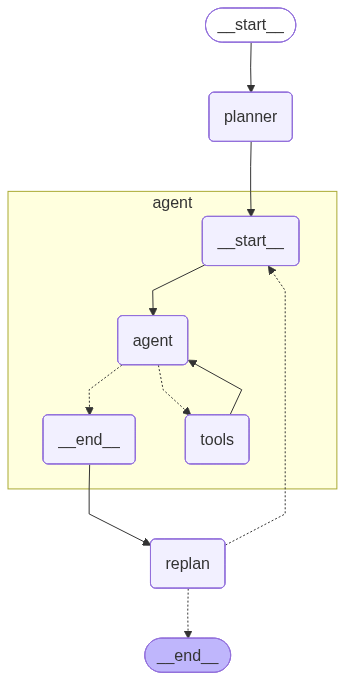

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png())) # 워크플로우 가시화

In [13]:
config = {"recursion_limit": 10} # 최대 10번의 워크플로우의 재귀 호출 허용
inputs = {"input": "일본 온천 여행하기 좋은 계절은?"}
async for event in graph.astream(inputs, config=config): # 워크플로우를 비동기적으로 실행
    for k, v in event.items(): # 워크플로우의 현재 상태("planner", "agent", "replan") 및 결과를 나타내는 딕셔너리
        if k != "__end__": # 상태가 "__end__"이 아닐 경우, 출력 데이터를 콘솔에 출력
            print(v)

{'plan': ['1. 일본의 계절별 기후를 조사합니다. 일본은 사계절이 뚜렷하며, 각 계절마다 기후가 다릅니다. 봄(3~5월), 여름(6~8월), 가을(9~11월), 겨울(12~2월)로 나뉩니다.', '2. 온천 여행에 적합한 기후 조건을 고려합니다. 일반적으로 온천은 추운 날씨에 더 즐기기 좋기 때문에, 기온이 낮고 쾌적한 계절을 선택하는 것이 좋습니다.', '3. 각 계절의 장단점을 분석합니다. 예를 들어, 겨울에는 눈이 내리는 지역에서 온천을 즐길 수 있어 낭만적이지만, 이동이 불편할 수 있습니다. 봄과 가을은 날씨가 온화하고 경치가 아름다워 여행하기 좋습니다.', '4. 일본의 유명 온천 지역을 조사합니다. 지역별로 계절에 따라 다른 매력을 느낄 수 있습니다. 예를 들어, 홋카이도는 겨울에 눈 온천을 즐기기 좋고, 교토는 봄에 벚꽃과 함께 온천을 즐길 수 있습니다.', '5. 여행 목적과 개인 취향에 맞는 계절을 선택합니다. 만약 눈 속에서 온천을 즐기고 싶다면 겨울이 적합하고, 꽃이 피는 계절을 선호한다면 봄이나 가을이 좋습니다.', '6. 최종적으로, 일본 온천 여행하기 좋은 계절은 개인의 취향과 여행 목적에 따라 다르지만, 일반적으로 가을(10~11월)과 겨울(12~2월)이 온천을 즐기기에 가장 좋은 계절로 평가됩니다.']}
{'past_steps': [('1. 일본의 계절별 기후를 조사합니다. 일본은 사계절이 뚜렷하며, 각 계절마다 기후가 다릅니다. 봄(3~5월), 여름(6~8월), 가을(9~11월), 겨울(12~2월)로 나뉩니다.', 'Here\'s an overview of Japan\'s climate, categorized by season for 2023:\n\n### Spring (March to May)\n- Springtime in Japan is characterized by the blooming of cherry blossoms, or sakura, which begins in the warmer southern regio